In [1]:
from __future__ import absolute_import, division, print_function

# Import TensorFlow >= 1.10 and enable eager execution
import tensorflow as tf
import gc 
from keras.utils import plot_model
from IPython.display import Image
tf.enable_eager_execution()
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import unicodedata
import re
import numpy as np
import os
import time
import string
print(tf.__version__)

Using TensorFlow backend.


1.13.1


In [2]:
lines = open(file = "../input/mar.txt", encoding='UTF-8').read().strip().split('\n')


In [3]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.strip())
    
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ." 
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    
    w = w.rstrip().strip()
    
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [4]:
exclude = set(string.punctuation) # Set of all special characters
remove_digits = str.maketrans('', '', string.digits) # Set of all digits
from sklearn.feature_extraction import stop_words

# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}


def preprocess_english(text,remove_stopwords = False):
    '''
    Given a text this function removes the punctuations, selected stopwords(because not, none convey some meaning and
    removing these stop words changes the meaning of the sentence.) and returns the length of the remaining text string
    '''
    refined_stop_words = {}
    if(remove_stopwords == True):
        refined_stop_words = stop_words.ENGLISH_STOP_WORDS-{ "not","none","nothing","nowhere","never",
                                                        "cannot","cant","couldnt","except","hasnt",
                                                        "neither","no","nobody","nor","without"
                                                           }
    try:
        #convert to lower case and strip regex
        new_text = ""
        text = text.lower()
        for word in text.split():
            if word in refined_stop_words:
                continue
            if word in contractions:
                new_text = new_text + " " + (contractions[word])
            else: 
                new_text = new_text + " " + word
        text = new_text
        regex = re.compile('[' + re.escape(string.punctuation) + '\\r\\t\\n]')
        text = regex.sub(" ", text)
        text = re.sub('\s+', ' ', text).strip()
        text = '<start> ' + text + ' <end>'
        return text
    except:
        return ""

def preprocess_marathi(s):
    s = re.sub("'", '', s) # remove the quotation marks if any
    s = ''.join(ch for ch in s if ch not in exclude)
    s = re.sub(" +", " ", s) # remove extra spaces
    s = '<start> ' + s + ' <end>' # add <start> and <end> tokens
    return s

In [5]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, MARATHI]
def create_dataset(path, num_examples):
    lines = open(file= "../input/mar.txt", encoding='UTF-8').read().strip().split('\n')

    # Generate pairs of cleaned English and Marathi sentences
    sent_pairs = []
    for line in lines:
        sent_pair = []
        eng, mar = line.split('\t')
        eng = preprocess_english(eng)
        sent_pair.append(eng)
        mar = preprocess_marathi(mar)
        sent_pair.append(mar)
        sent_pairs.append(sent_pair)
    
    return sent_pairs

In [6]:
# This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa 
# (e.g., 5 -> "dad") for each language,
class LanguageIndex():
    def __init__(self, lang):
        self.lang = lang
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()

        self.create_index()
    
    def create_index(self):
        for phrase in self.lang:
            self.vocab.update(phrase.split(' '))

        self.vocab = sorted(self.vocab)

        self.word2idx['<pad>'] = 0
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1

        for word, index in self.word2idx.items():
            self.idx2word[index] = word

In [7]:
def max_length(tensor):
    return max(len(t) for t in tensor)


def load_dataset(path, num_examples):
    # creating cleaned input, output pairs
    print("Creating marathi and english sentence pairs....")
    pairs = create_dataset(path, num_examples)
    print(pairs[0:5])
    
    # index language using the class defined above  
    print("Giving each word an index...")
    inp_lang = LanguageIndex(ma for en, ma in pairs)
    targ_lang = LanguageIndex(en for en, ma in pairs)
    
    # Vectorize the input and target languages
    
    # Marathi sentences
    print("text to sequences going on...")
    input_tensor = [[inp_lang.word2idx[s] for s in sp.split(' ')] for en, sp in pairs]
    
    # English sentences
    target_tensor = [[targ_lang.word2idx[s] for s in en.split(' ')] for en, sp in pairs]
    
    # Calculate max_length of input and output tensor
    # Here, we'll set those to the longest sentence in the dataset
    print("Finding out longest sentences...")
    max_length_inp, max_length_tar = max_length(input_tensor), max_length(target_tensor)
    
    # Padding the input and output tensor to the maximum length
    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                                 maxlen=max_length_inp,
                                                                 padding='post')
    
    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, 
                                                                  maxlen=max_length_tar, 
                                                                  padding='post')
    
    print("And we are done!!")
    return input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_tar

In [8]:
# Try experimenting with the size of that dataset
num_examples = 35398
input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_targ = load_dataset('../input/mar.txt', num_examples)

Creating marathi and english sentence pairs....
[['<start> go <end>', '<start> जा <end>'], ['<start> run <end>', '<start> पळ <end>'], ['<start> run <end>', '<start> धाव <end>'], ['<start> run <end>', '<start> पळा <end>'], ['<start> run <end>', '<start> धावा <end>']]
Giving each word an index...
text to sequences going on...
Finding out longest sentences...
And we are done!!


In [9]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(26980, 26980, 6745, 6745)

In [10]:
# See some tensors as well
input_tensor_train[0:2]

array([[    5,  5085,   643,  6852,  2586,  6526,     4,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [    5,  8529,  1256,  3399,   921, 12623,  8865,   840,     4,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)

### Create a tf.data dataset

In [11]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
N_BATCH = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word2idx)
vocab_tar_size = len(targ_lang.word2idx)

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

# Model

In [12]:
def gru(units):
  # If you have a GPU, we recommend using CuDNNGRU(provides a 3x speedup than GRU)
  # the code automatically does that.
    if tf.test.is_gpu_available():
        return tf.keras.layers.CuDNNGRU(units, 
                                        return_sequences=True, 
                                        return_state=True, 
                                        recurrent_initializer='glorot_uniform')
    else:
        return tf.keras.layers.GRU(units, 
                                   return_sequences=True, 
                                   return_state=True, 
                                   recurrent_activation='sigmoid', 
                                   recurrent_initializer='glorot_uniform')

In [13]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.enc_units)
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)        
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [14]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # used for attention
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying tanh(FC(EO) + FC(H)) to self.V
        score = self.V(tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis)))
        
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output shape == (batch_size * 1, vocab)
        x = self.fc(output)
        
        return x, state, attention_weights
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))

In [15]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

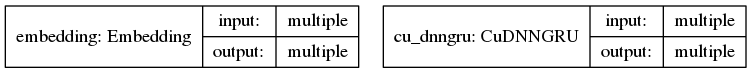

In [16]:
plot_model(encoder, to_file='encoder.png', show_shapes=True)
Image(filename='encoder.png')

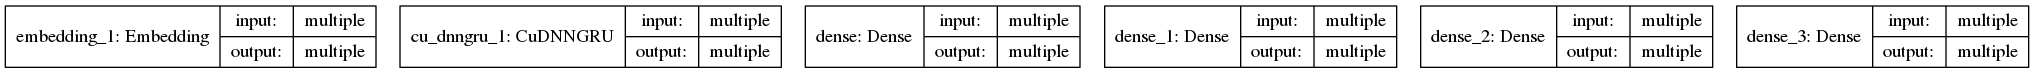

In [17]:
plot_model(decoder, to_file='decoder.png', show_shapes=True)
Image(filename='decoder.png')

In [18]:
optimizer = tf.train.AdamOptimizer()

def loss_function(real, pred):
    mask = 1 - np.equal(real, 0)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
    return tf.reduce_mean(loss_)

In [19]:
#To avoid memory issues!
gc.collect()

3756

In [20]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [21]:
EPOCHS = 20

for epoch in range(EPOCHS):
    start = time.time()
    
    hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0
        
        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(inp, hidden)
            
            dec_hidden = enc_hidden
            
            dec_input = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)       
            
            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                
                loss += loss_function(targ[:, t], predictions)
                
                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)
        
        batch_loss = (loss / int(targ.shape[1]))
        
        total_loss += batch_loss
        
        variables = encoder.variables + decoder.variables
        
        gradients = tape.gradient(loss, variables)
        
        optimizer.apply_gradients(zip(gradients, variables))
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 5 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.5291
Epoch 1 Batch 100 Loss 0.8007
Epoch 1 Batch 200 Loss 0.7145
Epoch 1 Batch 300 Loss 0.7365
Epoch 1 Batch 400 Loss 0.6299
Epoch 1 Loss 0.7603
Time taken for 1 epoch 383.72411346435547 sec

Epoch 2 Batch 0 Loss 0.5569
Epoch 2 Batch 100 Loss 0.5522
Epoch 2 Batch 200 Loss 0.5176
Epoch 2 Batch 300 Loss 0.5084
Epoch 2 Batch 400 Loss 0.4728
Epoch 2 Loss 0.5205
Time taken for 1 epoch 382.30272245407104 sec

Epoch 3 Batch 0 Loss 0.3955
Epoch 3 Batch 100 Loss 0.3446
Epoch 3 Batch 200 Loss 0.3893
Epoch 3 Batch 300 Loss 0.3562
Epoch 3 Batch 400 Loss 0.3321
Epoch 3 Loss 0.3691
Time taken for 1 epoch 378.1551904678345 sec

Epoch 4 Batch 0 Loss 0.2196
Epoch 4 Batch 100 Loss 0.2240
Epoch 4 Batch 200 Loss 0.2860
Epoch 4 Batch 300 Loss 0.2044
Epoch 4 Batch 400 Loss 0.2493
Epoch 4 Loss 0.2532
Time taken for 1 epoch 375.9341435432434 sec

Epoch 5 Batch 0 Loss 0.1795
Epoch 5 Batch 100 Loss 0.1448
Epoch 5 Batch 200 Loss 0.1598
Epoch 5 Batch 300 Loss 0.1842
Epoch 5 Batch 400 Loss 0

## Translate

In [22]:
def evaluate(inputs, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    sentence = ''
    for i in inputs[0]:
        if i == 0:
            break
        sentence = sentence + inp_lang.idx2word[i] + ' '
    sentence = sentence[:-1]
    
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word2idx['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.idx2word[predicted_id] + ' '

        if targ_lang.idx2word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot


In [23]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    cax = ax.matshow(attention)
    
    fontdict = {'fontsize': 15}
    
    ax.set_xticklabels([''] + [sentence], fontdict=fontdict)
    ax.set_yticklabels([''] + [predicted_sentence], fontdict=fontdict, rotation=90)
    fig.colorbar(cax)

    plt.show()

In [24]:
def translate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    result, sentence, attention_plot = evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
        
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(result))
    
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [25]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [26]:
import plotly.offline as pyo

init_notebook_mode(connected=True)

def predict_random_val_sentence():
    actual_sent = ''
    k = np.random.randint(len(input_tensor_val))
    random_input = input_tensor_val[k]
    random_output = target_tensor_val[k]
    random_input = np.expand_dims(random_input,0)
    result, sentence, attention_plot = evaluate(random_input, encoder, decoder, inp_lang, targ_lang, max_length_inp, 6)
    print('Input: {}'.format(sentence[8:-6]))
    print('Predicted translation: {}'.format(result[:-6]))
    for i in random_output:
        if i == 0:
            break
        actual_sent = actual_sent + targ_lang.idx2word[i] + ' '
    actual_sent = actual_sent[8:-7]
    print('Actual translation: {}'.format(actual_sent))
    attention_plot = attention_plot[:len(result.split(' '))-2, 1:len(sentence.split(' '))-1]
    sentence, result = sentence.split(' '), result.split(' ')
    sentence = sentence[1:-1]
    result = result[:-2]
    
    plot_attention(attention_plot, sentence, result)

    # use plotly to generate the heat map
    #trace = go.Heatmap(z = attention_plot, x = sentence, y = result, colorscale='Reds')
    #data=[trace]
    #iplot(data)

Input: चार गुणिले पाच म्हणजे वीस
Predicted translation: four hundred five percent o
Actual translation: four times five is twenty


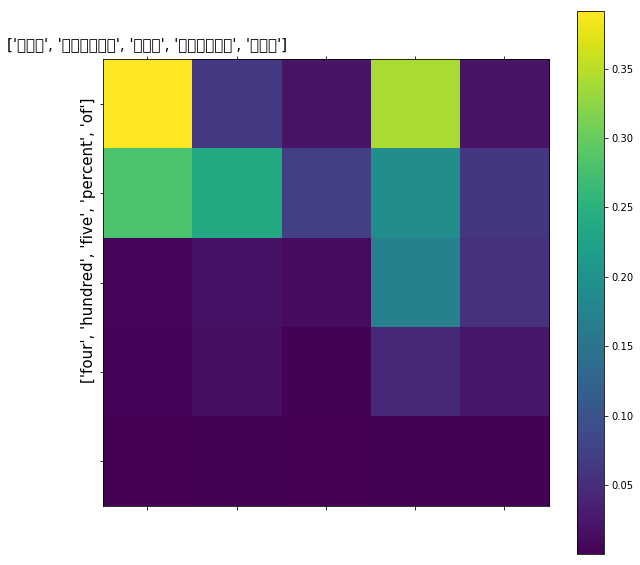

In [27]:
predict_random_val_sentence()

Input: तुम्ही पोर्क खाता का
Predicted translation: do you eat pork 
Actual translation: do you eat pork


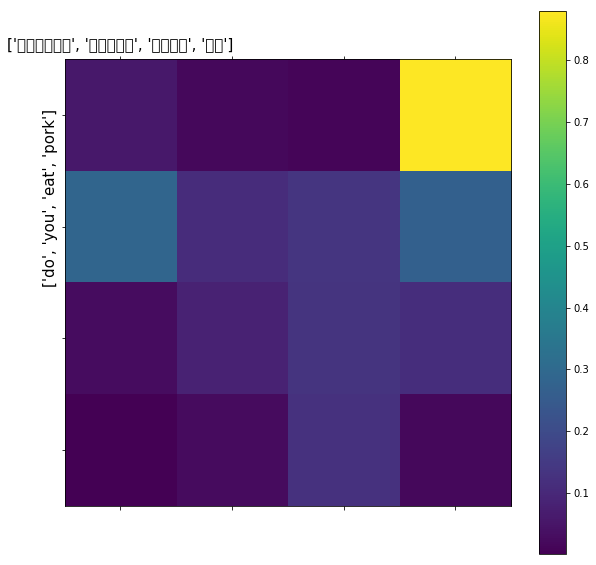

In [28]:
predict_random_val_sentence()

Input: त्याला कुठे जायचंय
Predicted translation: where does he want 
Actual translation: where does he want to go


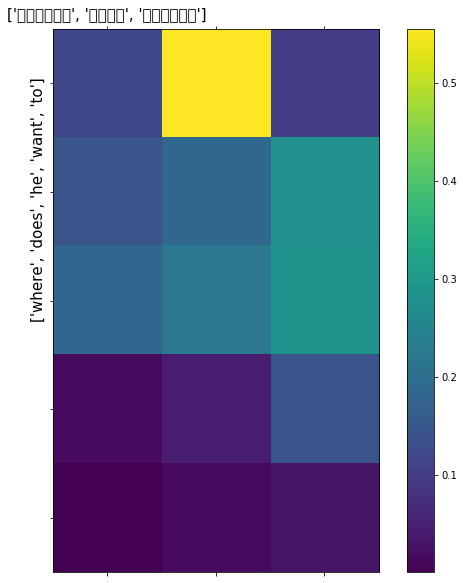

In [29]:
predict_random_val_sentence()

Input: टॉम माझ्या मुलांची काळजी घेतो
Predicted translation: tom can take care 
Actual translation: tom takes care of my children


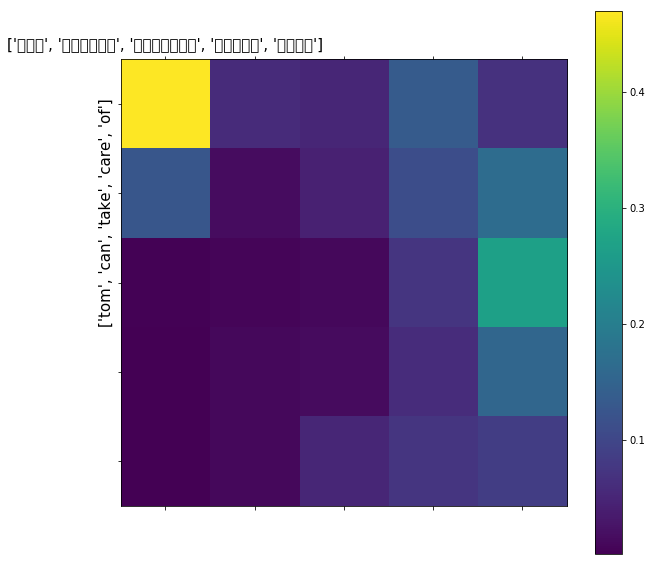

In [30]:
predict_random_val_sentence()

Input: मला कोणीच हरवू शकत नाही
Predicted translation: nobody can beat you 
Actual translation: nobody can beat me


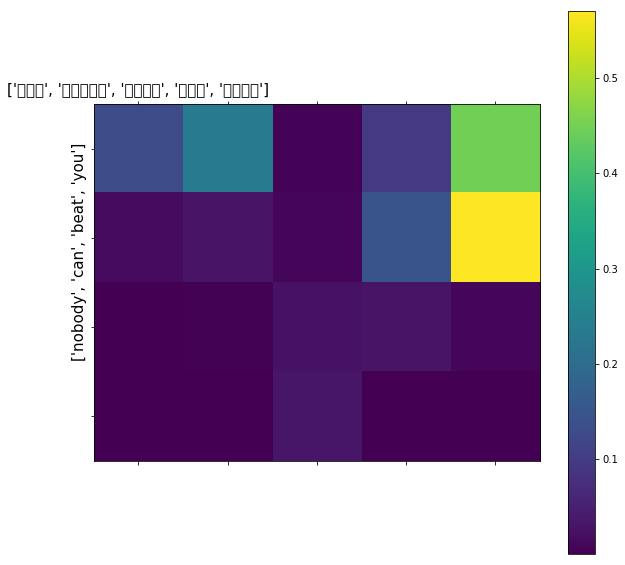

In [31]:
predict_random_val_sentence()

Input: ही खुर्ची हलकी आहे
Predicted translation: this chair is this 
Actual translation: this chair is light


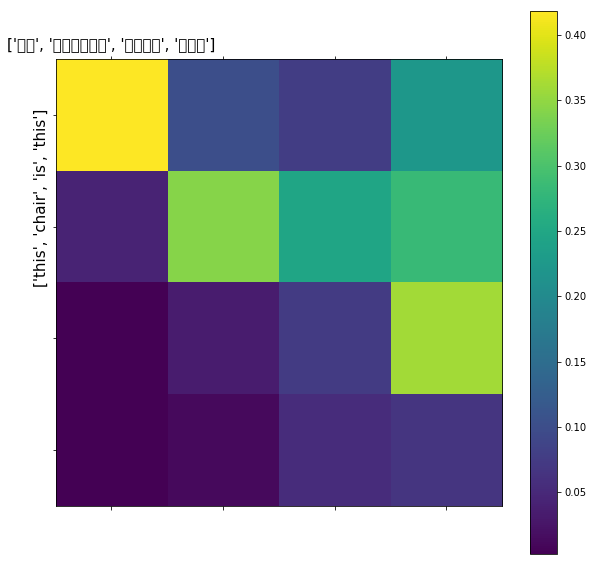

In [32]:
predict_random_val_sentence()

Input: टॉम माझ्या बहिणीचा मुलगा आहे
Predicted translation: tom is my son 
Actual translation: tom is my sister s boy


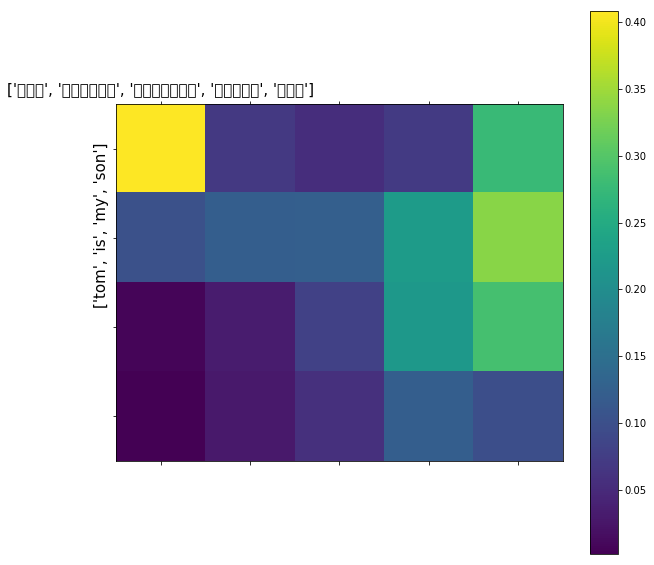

In [33]:
predict_random_val_sentence()

Input: आम्ही तुला बघू
Predicted translation: we will see you 
Actual translation: we will see you


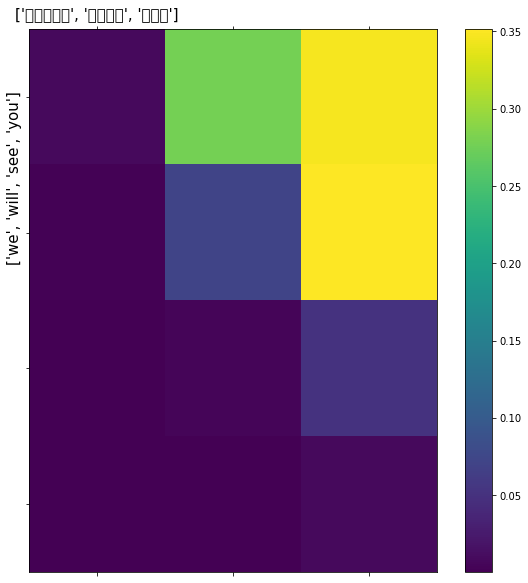

In [34]:
predict_random_val_sentence()